# Conditional variational autoencoder (using the VAE class)

# SETUP

In [1]:
!python --version


Python 3.6.7


In [2]:
%%bash
git clone https://github.com/masa-su/pixyz.git

fatal: destination path 'pixyz' already exists and is not an empty directory.


In [3]:
!apt-get update && apt-get install ffmpeg

Hit:1 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:3 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:4 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:5 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Ign:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1710/x86_64  InRelease
Ign:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1604/x86_64  InRelease
Hit:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1710/x86_64  Release
Hit:9 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1604/x86_64  Release
Reading package lists... Done
Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:3.4.4-0ubuntu0.18.04.1).
0 upgraded, 0 newly installed, 0 to remove and 62 not upgraded.


In [4]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch
!pip install tensorboardX
!pip install -e pixyz --process-dependency-links
torch.cuda.is_available()

Obtaining file:///content/pixyz
DEPRECATION: Dependency Links processing has been deprecated and will be removed in a future release. A possible replacement is PEP 508 URL dependencies. You can find discussion regarding this at https://github.com/pypa/pip/issues/4187.
  Found existing installation: pixyz 0.0.2
    Can't uninstall 'pixyz'. No files were found to uninstall.
  Running setup.py develop for pixyz


True

# CVAE

generative process

2dimention data

c=f(ut,s(t-1))

st~p(st|ut, s(t-1))=N(c , sigma)

ot~p(ot|st)=N(st,sigma)

それぞれの分散共分散行列には対角行列を使用（制御がめんどそうだから

In [0]:
from __future__ import print_function
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
from tensorboardX import SummaryWriter
import numpy as np

from tqdm import tqdm

batch_size = 128
epochs =50#10
seed = 1
torch.manual_seed(seed)

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

In [0]:
root = '../data'
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Lambda(lambd=lambda o: o.view(-1))])
kwargs = {'batch_size': batch_size, 'num_workers': 1, 'pin_memory': True}

# train_loader = torch.utils.data.DataLoader(
#     datasets.MNIST(root=root, train=True, transform=transform, download=True),
#     shuffle=True, **kwargs)
# test_loader = torch.utils.data.DataLoader(
#     datasets.MNIST(root=root, train=False, transform=transform),
#     shuffle=False, **kwargs)

In [0]:
from pixyz.distributions import Normal, Bernoulli
from pixyz.losses import KullbackLeibler
from pixyz.models import VAE

In [0]:
#function for generate data
import torch.distributions as dist

def origin_datagenerator(sample_num,dsigma,axis):
  ca_axis=[-3,-2]
  cb_axis=[3,3]
  cc_axis=[7,5]
  
  data_cso={}
  
  ones=torch.ones(int(sample_num/3))
  
  sample_ca = torch.stack([ones*axis[0][0],ones*axis[0][1]],1)
  sample_cb = torch.stack([ones*axis[1][0],ones*axis[1][1]],1)
  sample_cc = torch.stack([ones*axis[2][0],ones*axis[2][1]],1)
  data_cso.update({"c":torch.cat([sample_ca,sample_cb,sample_cc],dim=0)})
  data_cso.update({"s":dist.Normal(data_cso["c"],dsigma).sample()})
  data_cso.update({"o":dist.Normal(data_cso["s"],dsigma).sample()})
#   data_cso.update([ ("c",torch.cat([sample_ca,sample_cb,sample_cc],dim=0)), ("s",dist.Normal(data_cso["c"],dsigma).sample()) ])
  
  return data_cso
  
def unique_datagenerator(sample_num,dsigma):
  data_cso={}
  
  sample_c1=torch.rand(sample_num)*100#一様分布からの場合
  sample_c2=torch.rand(sample_num)*100
  data_cso.update({"c":torch.cat([sample_c1.view(sample_num,1),sample_c2.view(sample_num,1)],dim=1)})
  data_cso.update({"s":dist.Normal(data_cso["c"],dsigma).sample()})
  data_cso.update({"o":dist.Normal(data_cso["s"],dsigma).sample()})
  
  return data_cso

In [9]:
sample_num=3000
dsigma=torch.Tensor([0.3,0.3]*sample_num).view(sample_num,2)

axis=[[-3,-2],[3,3],[7,5]]

max_data=10.0
min_data=-2.0

data=origin_datagenerator(sample_num,dsigma,axis)
test_data=origin_datagenerator(sample_num,dsigma,axis)

print(data)

train = torch.utils.data.TensorDataset(data["o"], data["c"])
train_loader = torch.utils.data.DataLoader(train, shuffle=False,**kwargs)
test = torch.utils.data.TensorDataset(test_data["o"], test_data["c"])
test_loader = torch.utils.data.DataLoader(test, shuffle=False,**kwargs)

{'c': tensor([[-3., -2.],
        [-3., -2.],
        [-3., -2.],
        ...,
        [ 7.,  5.],
        [ 7.,  5.],
        [ 7.,  5.]]), 's': tensor([[-3.4577, -2.2251],
        [-3.1962, -2.4828],
        [-3.0301, -2.1828],
        ...,
        [ 6.9832,  4.6315],
        [ 7.3433,  4.8847],
        [ 7.0353,  5.1951]]), 'o': tensor([[-3.3020, -2.5129],
        [-3.3875, -2.7370],
        [-3.7485, -2.4868],
        ...,
        [ 6.8752,  5.3474],
        [ 7.5651,  5.1852],
        [ 6.9225,  5.0590]])}


In [0]:
o_dim = 2
c_dim = 2
s_dim = 2


# inference model q(z|x,y)
class Inference(Normal):
    def __init__(self):
        super(Inference, self).__init__(cond_var=["o","c"], var=["s"], name="q")

        self.fc1 = nn.Linear(o_dim+c_dim, 4)
        self.fc2 = nn.Linear(4, 4)
        self.fc31 = nn.Linear(4, s_dim)
        self.fc32 = nn.Linear(4, s_dim)

    def forward(self, o, c):
        h = F.relu(self.fc1( torch.cat([o,c],1) ))
        h = F.relu(self.fc2(h))        
        return {"loc": self.fc31(h), "scale": F.softplus(self.fc32(h))}

    
# generative model p(x|z,y)    
class Generator(Bernoulli):
    def __init__(self):
        super(Generator, self).__init__(cond_var=["s"], var=["o"], name="p")

        self.fc1 = nn.Linear(s_dim, 4)
        self.fc2 = nn.Linear(4, 4)
        self.fc3 = nn.Linear(4, o_dim)

    def forward(self, s):
#         print(s)
#         print(s.shape)
        h = F.relu(self.fc1(s))
        h = F.relu(self.fc2(h))
        return {"probs": torch.sigmoid(self.fc3(h))}
    
class Generator2(Normal):
    def __init__(self):
        super().__init__(cond_var=["s"], var=["o"], name="p")

        self.fc1 = nn.Linear(s_dim, 4)
        self.fc2 = nn.Linear(4, 4)
        self.fc3 = nn.Linear(4, o_dim)

    def forward(self, s):
#         print(s)
#         print(s.shape)
        h = F.relu(self.fc1(s))
        h = F.relu(self.fc2(h))
        return {"loc": self.fc3(h),"scale":0.3}

#     def forward(self, s, c):
#         print(s)
#         print(c.view(1))
#         c=c.view(1)
#         print(s.shape)
#         print(c.shape)
#         print(s.size())
#         print(c.size())
#         sc=[]
#         sc.append(s)
#         sc.append(c)
#         aa=self.fc1(torch.stack(sc, 0))
#         h = F.relu(aa)
#         h = F.relu(self.fc2(h))
#         return {"probs": torch.sigmoid(self.fc3(h))}

      
    

# prior = Normal(loc=loc, scale=scale, cond_var=["c"],var=["s"], dim=s_dim, name="p_prior")

In [11]:
# prior model p(z|c)
class prior_set(Normal):
    def forward(self, c):
        return{"loc":c, "scale":torch.tensor([0.3,0.3]).to(device)}
      
prior = prior_set(cond_var=["c"],var=["s"], dim=s_dim, name="p_prior")
print(prior)

Distribution:
  p_prior(s|c) (Normal)
Network architecture:
  prior_set()


In [12]:
p = Generator2()
q = Inference()

p.to(device)
q.to(device)

print(p)
print(q)

Distribution:
  p(o|s) (Normal)
Network architecture:
  Generator2(
    (fc1): Linear(in_features=2, out_features=4, bias=True)
    (fc2): Linear(in_features=4, out_features=4, bias=True)
    (fc3): Linear(in_features=4, out_features=2, bias=True)
  )
Distribution:
  q(s|o,c) (Normal)
Network architecture:
  Inference(
    (fc1): Linear(in_features=4, out_features=4, bias=True)
    (fc2): Linear(in_features=4, out_features=4, bias=True)
    (fc31): Linear(in_features=4, out_features=2, bias=True)
    (fc32): Linear(in_features=4, out_features=2, bias=True)
  )


In [13]:
kl = KullbackLeibler(q, prior)
print(kl)

KL[q(s|o,c)||p_prior(s|c)]


In [14]:
model = VAE(q, p, regularizer=kl, optimizer=optim.Adam, optimizer_params={"lr":1e-3})
print(model)

Distributions (for training): 
  q(s|o,c), p(o|s) 
Loss function: 
  mean(-E_q(s|o,c)[log p(o|s)] + KL[q(s|o,c)||p_prior(s|c)]) 
Optimizer: 
  Adam (
  Parameter Group 0
      amsgrad: False
      betas: (0.9, 0.999)
      eps: 1e-08
      lr: 0.001
      weight_decay: 0
  )


In [0]:
def train(epoch):
    train_loss = 0
    for o,c in tqdm(train_loader):
        o = o.to(device)
        c = c.to(device)
#         print(o.size())
#         print(c.size())
#         print(o)
        loss = model.train({"o": o, "c": c})
        train_loss += loss
        
#     print(kl.gauss_gauss_kl(, scale1, loc2, scale2, dim=None))
    train_loss = train_loss * train_loader.batch_size / len(data["c"])
    print('Epoch: {} Train loss: {:.4f}'.format(epoch, train_loss))
    return train_loss

In [0]:
# print(train_loader.batch_size)
# print(len(train_loader))
# print(dc)

In [0]:
def test(epoch):
    test_loss = 0
    for o, c in test_loader:
        o = o.to(device)
        c = c.to(device)
        loss = model.test({"o": o, "c": c})
        test_loss += loss
        

    test_loss = test_loss * test_loader.batch_size / len(test_data["c"])
    print('Test loss: {:.4f}'.format(test_loss))
    return test_loss

In [0]:
# model.test({"o":do[0].unsqueeze(0).to(device),"c":dc[0].unsqueeze(0).to(device)})
# q.sample("o":do[0],"c":dc[0], return_all=False)

In [0]:
def plot_reconstrunction(o, c):
    with torch.no_grad():
        s = q.sample({"o": o, "c": c}, return_all=False)
        s.update({"c": c})
        recon_batch = p.sample_mean(s).view(-1, 1, 28, 28)
    
        recon = torch.cat([o.view(-1, 1, 28, 28), recon_batch]).cpu()
        return recon
    
def plot_image_from_latent(s, c):
    with torch.no_grad():
        sample = p.sample_mean({"s": s, "c": c}).view(-1, 1, 28, 28).cpu()
        return sample
    
def plot_reconstrunction_changing_y(o, c):
    c_change = torch.eye(10)[range(7)].to(device)
    batch_dummy = torch.ones(o.size(0))[:, None].to(device)    
    recon_all = []
    
    with torch.no_grad():
        for _c in c_change:
            s = q.sample({"o": o, "c": c}, return_all=False)
            s.update({"c": batch_dummy * _c[None,:]})
            recon_batch = p.sample_mean(s).view(-1, 1, 28, 28)
            recon_all.append(recon_batch)
    
        recon_changing_c = torch.cat(recon_all)
        recon_changing_c = torch.cat([o.view(-1, 1, 28, 28), recon_changing_c]).cpu()
        return recon_changing_c

In [0]:
#prepare for plot
import matplotlib.animation as animation
import matplotlib.pyplot as plt
from matplotlib import rc
from IPython.display import HTML
history = {"train_loss":[],"test_loss":[]}

ims=[]#animation variable
# sample_s=dist.Normal(dc,dsigma).sample()
# sample_o=dist.Normal(sample_s,dsigma).sample()

grid_inter=1.0

plt.xlim([min_data,max_data])
plt.ylim([min_data,max_data])

plt.xlabel('$sx$', fontsize=16)
plt.ylabel('$sy$', fontsize=16)
plt.title("Simulated dataset")

# plt.xticks(np.arange(-2,6,1.0))

In [50]:
q.rsample()

AttributeError: ignored

100%|██████████| 24/24 [00:00<00:00, 83.98it/s]

Epoch: 1 Train loss: 393.2765


Test loss: 390.1160


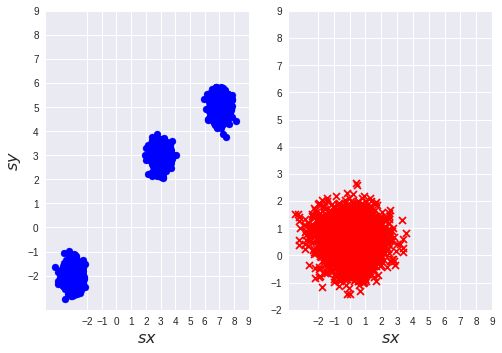

100%|██████████| 24/24 [00:00<00:00, 82.41it/s]

Epoch: 2 Train loss: 384.9302


Test loss: 383.2496


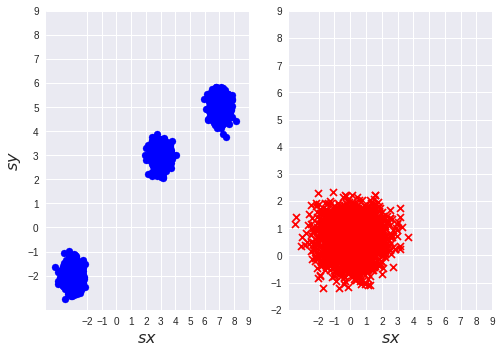

100%|██████████| 24/24 [00:00<00:00, 84.24it/s]

Epoch: 3 Train loss: 378.9855


Test loss: 377.4044


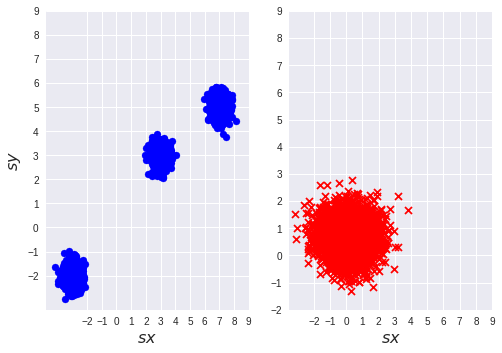

100%|██████████| 24/24 [00:00<00:00, 81.23it/s]

Epoch: 4 Train loss: 373.0453


Test loss: 371.0829


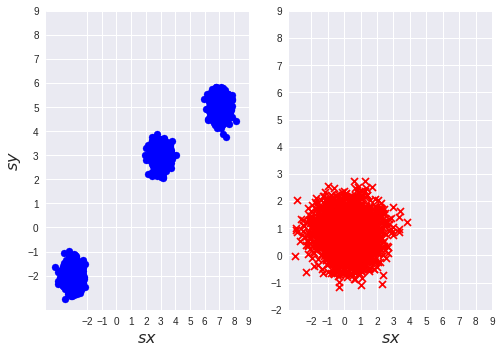

100%|██████████| 24/24 [00:00<00:00, 86.87it/s]

Epoch: 5 Train loss: 365.6574


Test loss: 362.9439


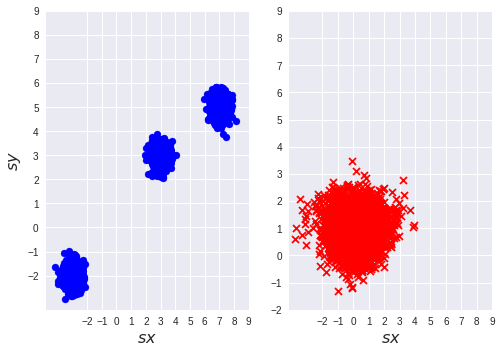

100%|██████████| 24/24 [00:00<00:00, 84.45it/s]

Epoch: 6 Train loss: 356.2167


Test loss: 352.7415


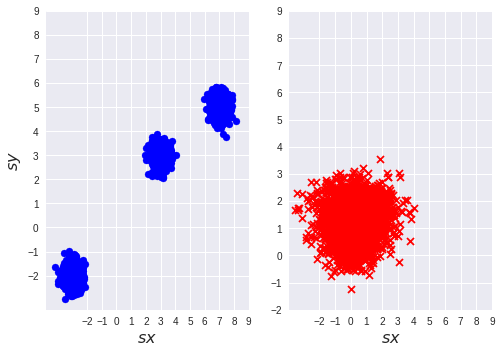

100%|██████████| 24/24 [00:00<00:00, 82.42it/s]

Epoch: 7 Train loss: 344.9750


Test loss: 340.9160


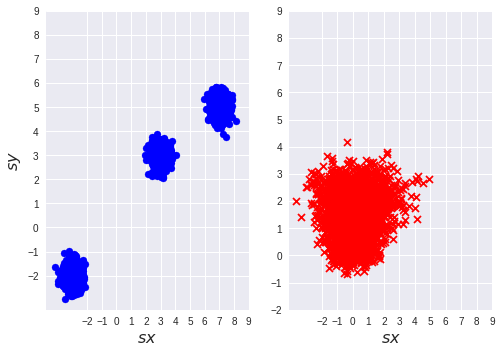

100%|██████████| 24/24 [00:00<00:00, 87.31it/s]

Epoch: 8 Train loss: 332.2628


Test loss: 327.7052


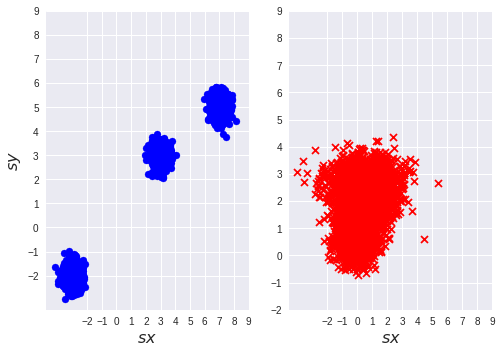

100%|██████████| 24/24 [00:00<00:00, 86.01it/s]

Epoch: 9 Train loss: 318.2054


Test loss: 312.8885


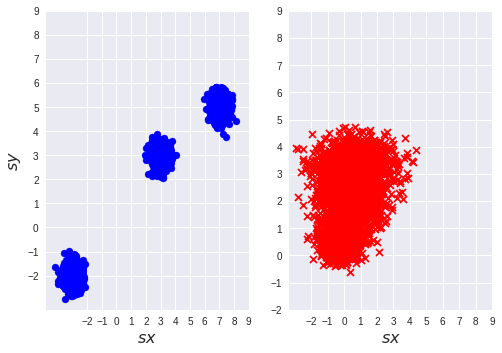

100%|██████████| 24/24 [00:00<00:00, 87.04it/s]

Epoch: 10 Train loss: 301.8469


Test loss: 295.5735


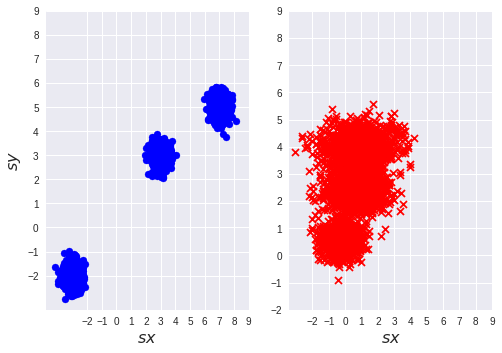

100%|██████████| 24/24 [00:00<00:00, 85.59it/s]

Epoch: 11 Train loss: 283.3285


Test loss: 276.6254


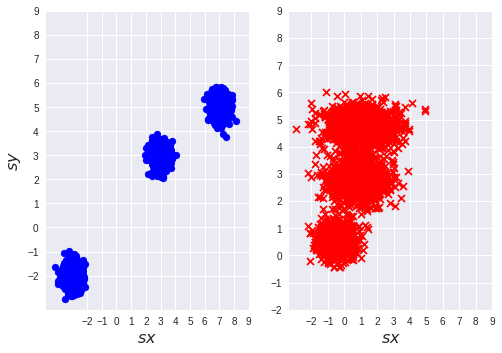

100%|██████████| 24/24 [00:00<00:00, 85.95it/s]

Epoch: 12 Train loss: 263.3532


Test loss: 255.8172


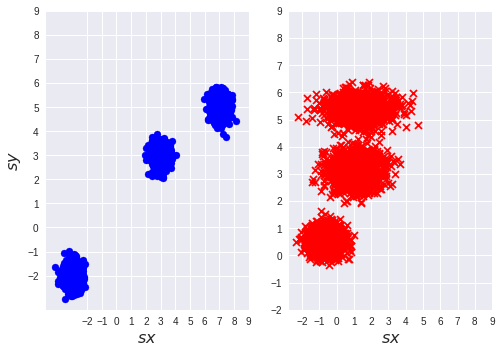

100%|██████████| 24/24 [00:00<00:00, 87.10it/s]

Epoch: 13 Train loss: 241.2560


Test loss: 233.1607


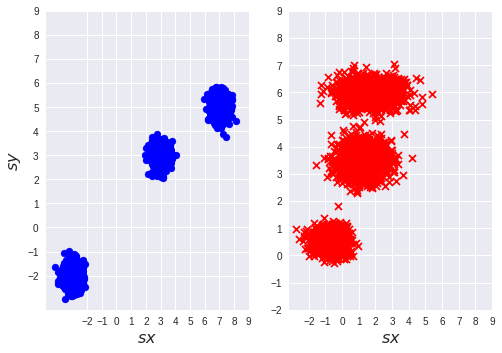

100%|██████████| 24/24 [00:00<00:00, 84.33it/s]

Epoch: 14 Train loss: 217.8243


Test loss: 209.2851


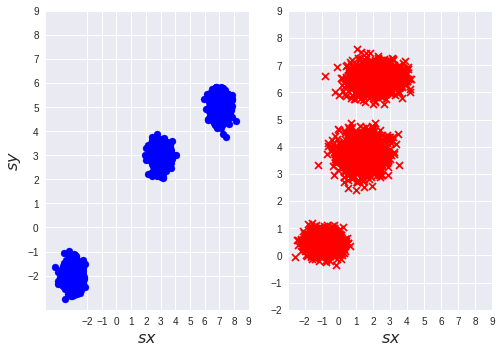

100%|██████████| 24/24 [00:00<00:00, 83.04it/s]

Epoch: 15 Train loss: 193.7003


Test loss: 184.9965


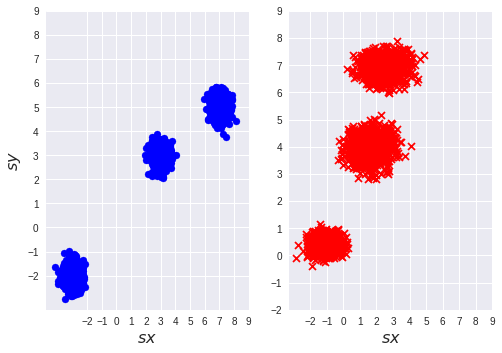

100%|██████████| 24/24 [00:00<00:00, 85.77it/s]

Epoch: 16 Train loss: 169.9956


Test loss: 161.2431


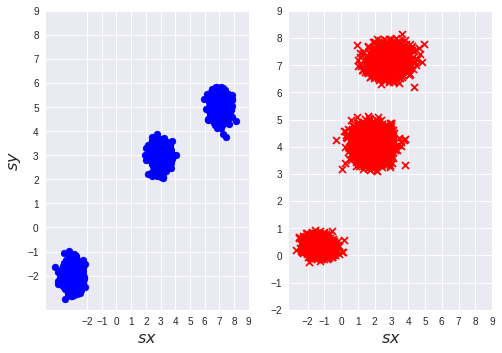

100%|██████████| 24/24 [00:00<00:00, 84.64it/s]

Epoch: 17 Train loss: 146.9247


Test loss: 137.8533


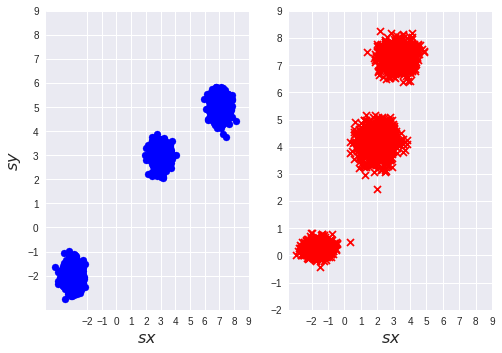

100%|██████████| 24/24 [00:00<00:00, 85.73it/s]

Epoch: 18 Train loss: 124.8487


Test loss: 115.2102


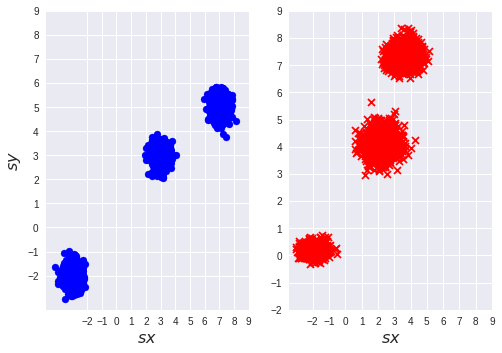

100%|██████████| 24/24 [00:00<00:00, 83.81it/s]

Epoch: 19 Train loss: 103.6120


Test loss: 93.3882


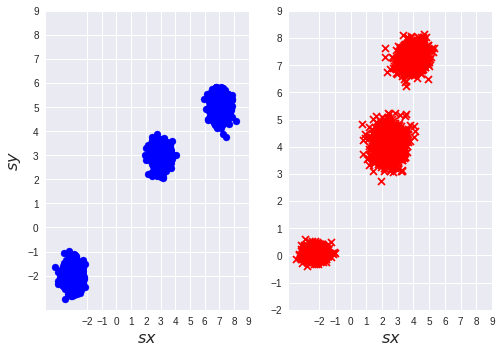

100%|██████████| 24/24 [00:00<00:00, 79.41it/s]

Epoch: 20 Train loss: 83.2929


Test loss: 73.1977


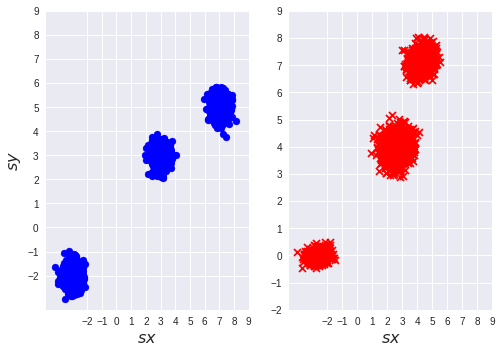

100%|██████████| 24/24 [00:00<00:00, 83.80it/s]

Epoch: 21 Train loss: 64.7072


Test loss: 55.3698


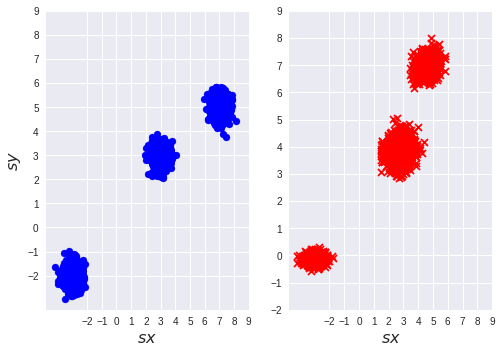

100%|██████████| 24/24 [00:00<00:00, 85.76it/s]

Epoch: 22 Train loss: 48.5520


Test loss: 41.2823


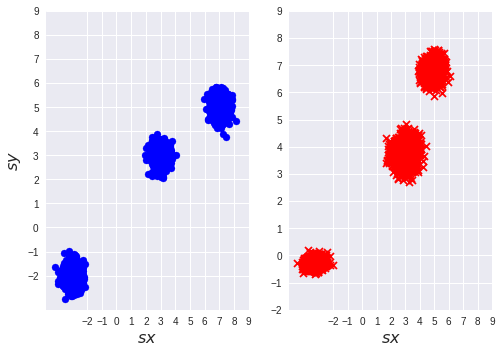

100%|██████████| 24/24 [00:00<00:00, 87.07it/s]

Epoch: 23 Train loss: 36.1687


Test loss: 31.5766


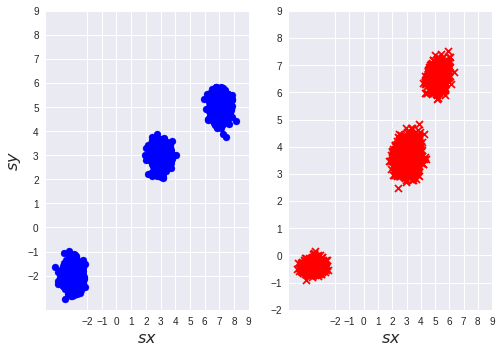

100%|██████████| 24/24 [00:00<00:00, 84.26it/s]

Epoch: 24 Train loss: 27.7753


Test loss: 25.0379


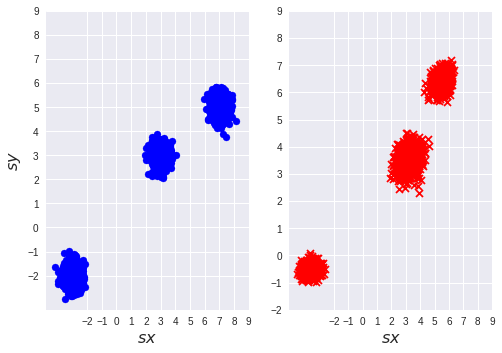

100%|██████████| 24/24 [00:00<00:00, 81.02it/s]


Epoch: 25 Train loss: 22.2402
Test loss: 20.3019


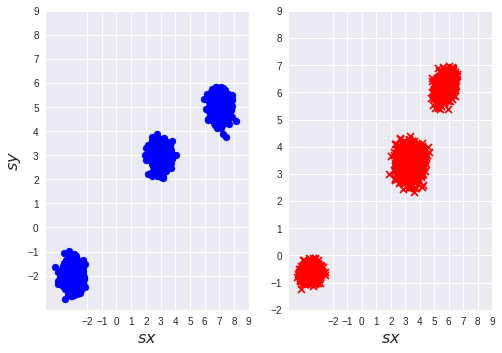

100%|██████████| 24/24 [00:00<00:00, 81.38it/s]

Epoch: 26 Train loss: 18.1848


Test loss: 16.6348


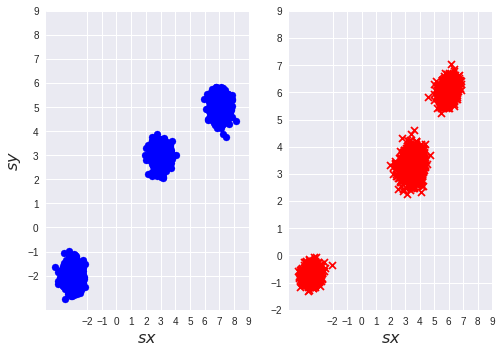

100%|██████████| 24/24 [00:00<00:00, 82.74it/s]

Epoch: 27 Train loss: 15.1537


Test loss: 13.9151


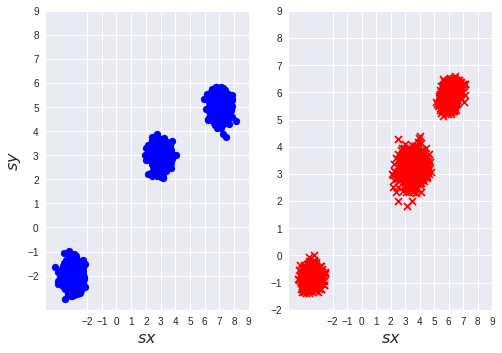

100%|██████████| 24/24 [00:00<00:00, 80.30it/s]

Epoch: 28 Train loss: 12.9423


Test loss: 11.8657


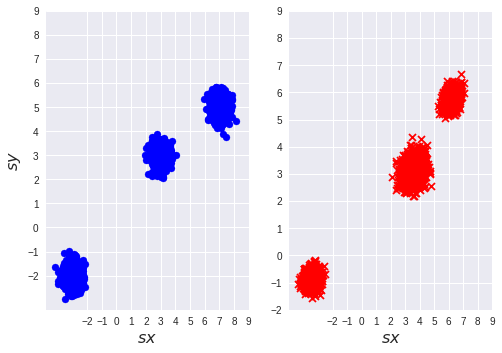

100%|██████████| 24/24 [00:00<00:00, 78.42it/s]

Epoch: 29 Train loss: 11.1774


Test loss: 10.3178


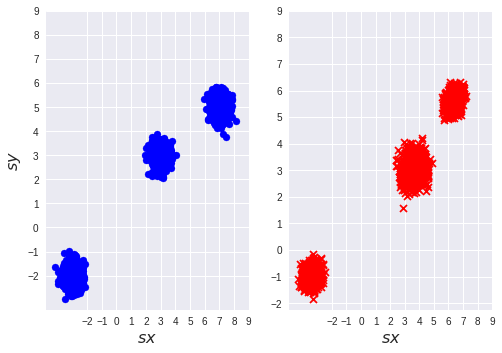

100%|██████████| 24/24 [00:00<00:00, 79.68it/s]

Epoch: 30 Train loss: 9.9509


Test loss: 9.1501


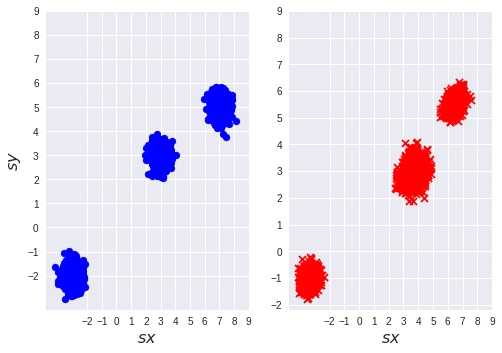

100%|██████████| 24/24 [00:00<00:00, 81.25it/s]

Epoch: 31 Train loss: 8.9485


Test loss: 8.2127


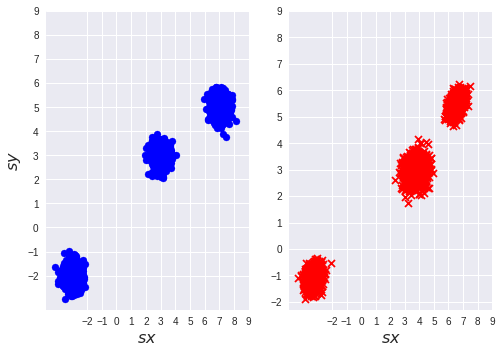

100%|██████████| 24/24 [00:00<00:00, 83.02it/s]

Epoch: 32 Train loss: 8.1609


Test loss: 7.5318


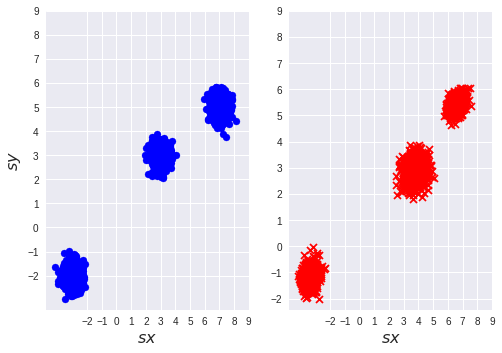

100%|██████████| 24/24 [00:00<00:00, 82.84it/s]

Epoch: 33 Train loss: 7.5360


Test loss: 6.9990


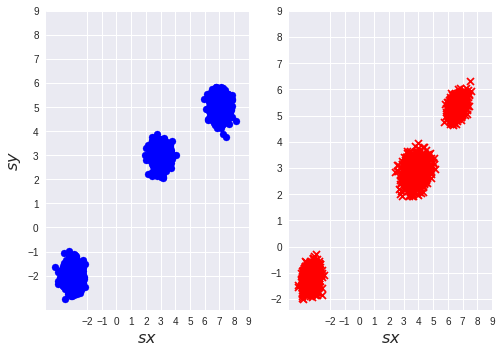

100%|██████████| 24/24 [00:00<00:00, 83.46it/s]

Epoch: 34 Train loss: 7.0106


Test loss: 6.5601


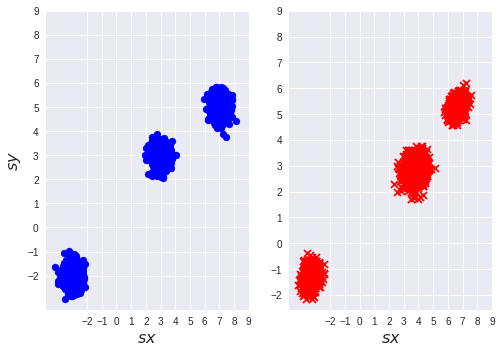

100%|██████████| 24/24 [00:00<00:00, 85.35it/s]

Epoch: 35 Train loss: 6.6301


Test loss: 6.1386


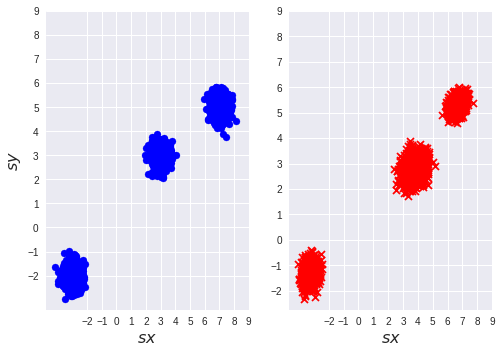

100%|██████████| 24/24 [00:00<00:00, 81.63it/s]

Epoch: 36 Train loss: 6.3337


Test loss: 5.8445


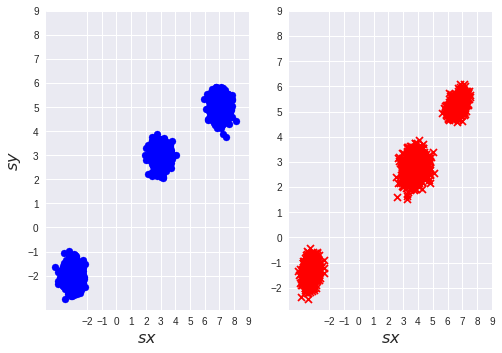

100%|██████████| 24/24 [00:00<00:00, 82.20it/s]

Epoch: 37 Train loss: 5.9917


Test loss: 5.5788


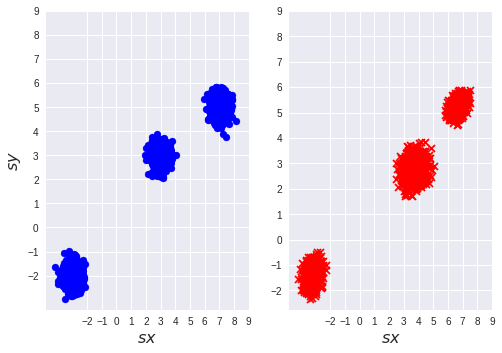

100%|██████████| 24/24 [00:00<00:00, 84.92it/s]

Epoch: 38 Train loss: 5.7720


Test loss: 5.3279


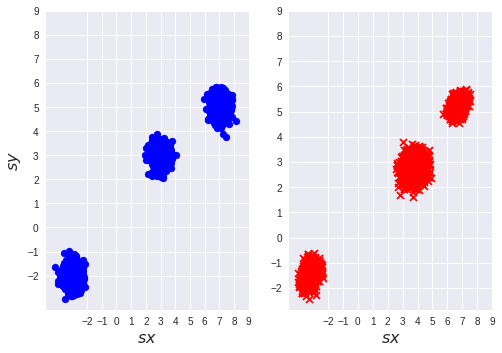

100%|██████████| 24/24 [00:00<00:00, 86.03it/s]

Epoch: 39 Train loss: 5.5961


Test loss: 5.1656


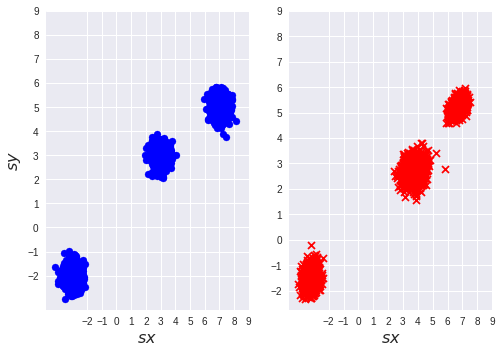

100%|██████████| 24/24 [00:00<00:00, 83.41it/s]

Epoch: 40 Train loss: 5.3938


Test loss: 4.9822


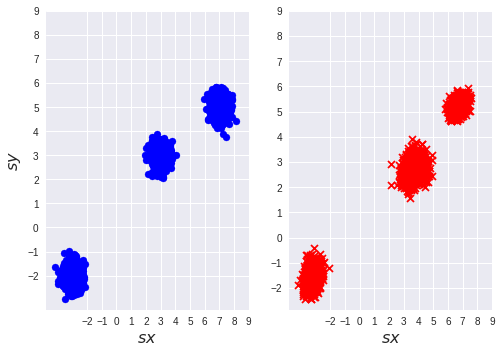

100%|██████████| 24/24 [00:00<00:00, 83.00it/s]

Epoch: 41 Train loss: 5.1939


Test loss: 4.8919


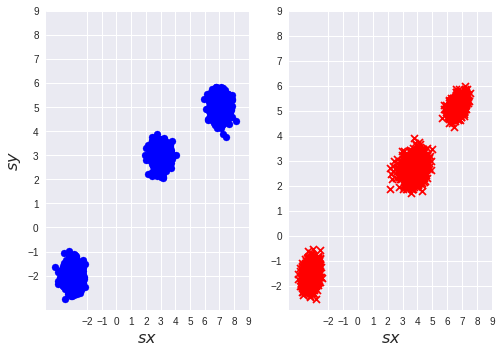

100%|██████████| 24/24 [00:00<00:00, 87.93it/s]

Epoch: 42 Train loss: 5.0903


Test loss: 4.7437


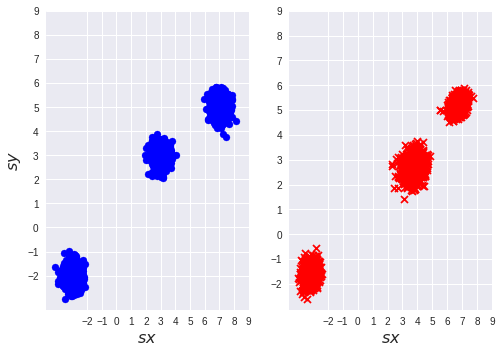

100%|██████████| 24/24 [00:00<00:00, 82.83it/s]

Epoch: 43 Train loss: 4.9468


Test loss: 4.6350


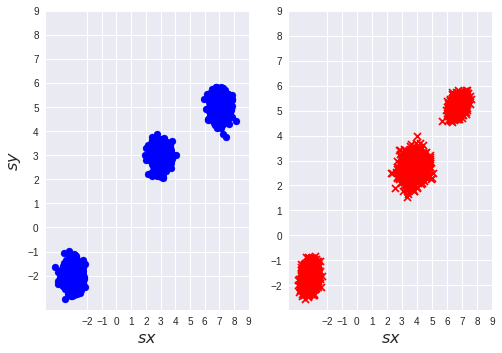

100%|██████████| 24/24 [00:00<00:00, 87.21it/s]

Epoch: 44 Train loss: 4.9292


Test loss: 4.5584


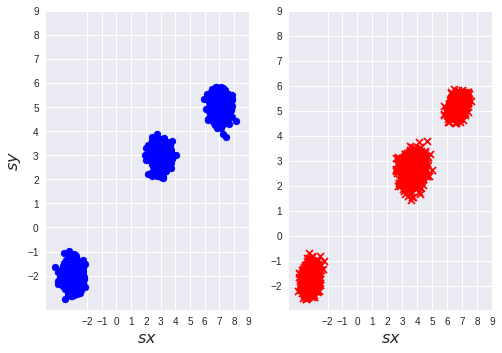

100%|██████████| 24/24 [00:00<00:00, 85.53it/s]

Epoch: 45 Train loss: 4.7786


Test loss: 4.4401


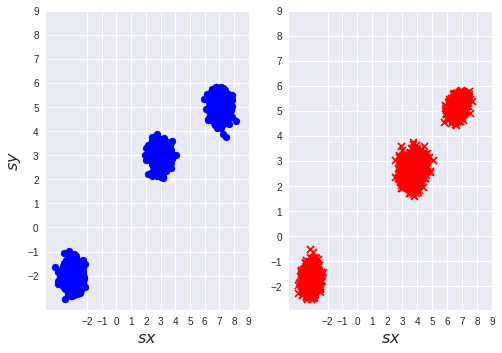

100%|██████████| 24/24 [00:00<00:00, 81.78it/s]

Epoch: 46 Train loss: 4.6728


Test loss: 4.3470


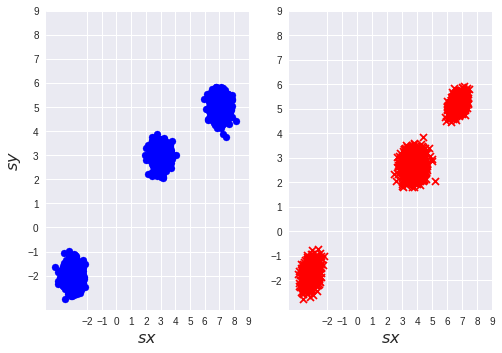

100%|██████████| 24/24 [00:00<00:00, 79.68it/s]

Epoch: 47 Train loss: 4.5767


Test loss: 4.2729


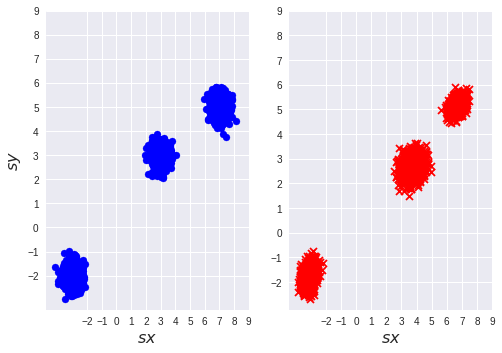

100%|██████████| 24/24 [00:00<00:00, 83.50it/s]

Epoch: 48 Train loss: 4.5930


Test loss: 4.2585


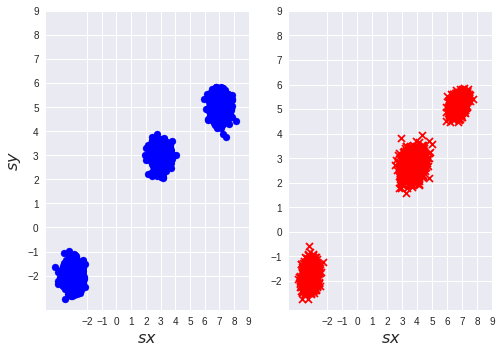

100%|██████████| 24/24 [00:00<00:00, 84.24it/s]

Epoch: 49 Train loss: 4.4479


Test loss: 4.1401


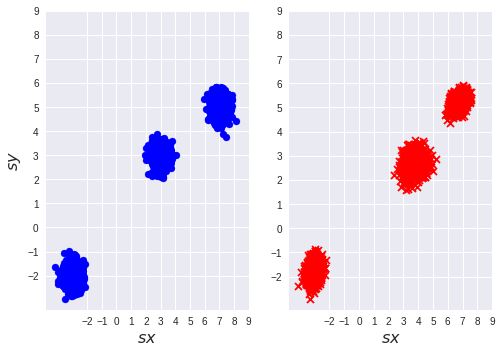

100%|██████████| 24/24 [00:00<00:00, 82.85it/s]

Epoch: 50 Train loss: 4.3853


Test loss: 4.1877


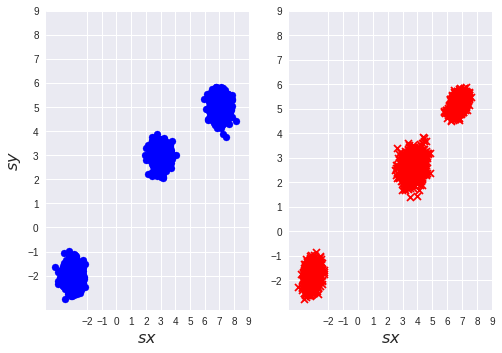

In [21]:
writer = SummaryWriter()

plot_number = 1

s_sample = 0.5 * torch.randn(64, s_dim).to(device)
c_sample = torch.eye(10)[[plot_number]*64].to(device)

# _o, _c = iter(test_loader).next()
# _o = _o.to(device)
# _c = torch.eye(10)[_c].to(device)


for epoch in range(1, epochs + 1):
    train_loss = train(epoch)
    test_loss = test(epoch)
    
#     recon = plot_reconstrunction(_o[:8], _c[:8])
#     sample = plot_image_from_latent(s_sample, c_sample)
#     recon_changing_c = plot_reconstrunction_changing_c(_o[:8], _c[:8])

    writer.add_scalar('train_loss', train_loss.item(), epoch)
    writer.add_scalar('test_loss', test_loss.item(), epoch)
    
    #for plot
    history["train_loss"].append(train_loss.item())
    history["test_loss"].append(test_loss.item())

    _s = q.sample({"o": data["o"].to(device), "c": data["c"].to(device)}, return_all=False)
    plt.subplot(1, 2, 1)
    tru = plt.scatter(data["s"][:,0],data["s"][:,1],color='blue',marker='o',edgecolors="blue")
    plt.xticks(np.arange(min_data,max_data,grid_inter))
    plt.yticks(np.arange(min_data,max_data,grid_inter))
    plt.ylabel('$sy$', fontsize=16)
    plt.xlabel('$sx$', fontsize=16)
    
    plt.subplot(1, 2, 2)
    sam = plt.scatter(_s["s"][:,0],_s["s"][:,1],color='red',marker='x',edgecolors="red")
    plt.xticks(np.arange(min_data,max_data,grid_inter))
    plt.yticks(np.arange(min_data,max_data,grid_inter))
    plt.xlabel('$sx$', fontsize=16)
    ims.append([tru]+[sam])
    plt.show()
    

#     writer.add_image('Image_from_latent', sample, epoch)
#     writer.add_image('Image_reconstrunction', recon, epoch)
#     writer.add_image('Image_reconstrunction_change_c', recon_changing_c, epoch)
    
writer.close()

In [0]:
# #animation
# def iinit():    
#     return (ims[0])
# # animation function: this is called sequentially
# def animate(i):
#   return (ims[i])

# #plot gif
# fig = plt.figure()
# plt.legend(['True','Result'], loc='upper left', fontsize=16)
# ani = animation.ArtistAnimation(fig, ims)
# anim = animation.FuncAnimation(fig, animate, init_func=iinit, frames=epochs, interval=100, blit=True)
# plt.rcParams['animation.ffmpeg_path'] = '/usr/bin/ffmpeg' # For google colab
# HTML(ani.to_html5_video())
# rc('animation', html='jshtml')
# anim

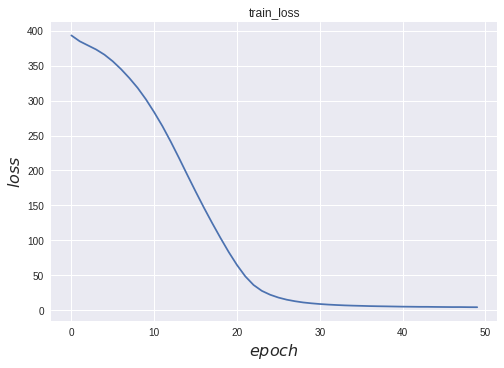

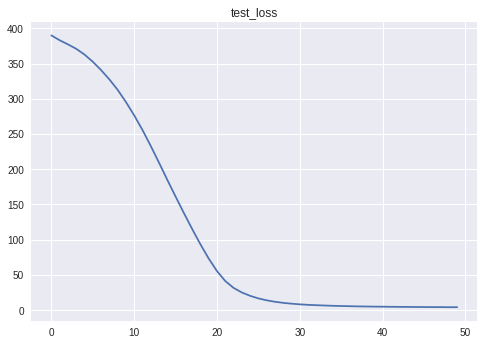

In [23]:
#plot loss    
plt.ylabel('$loss$', fontsize=16)
plt.xlabel('$epoch$', fontsize=16)
plt.title("train_loss")
plt.plot(range(epochs), history["train_loss"])
plt.show()
plt.title("test_loss")
plt.plot(range(epochs), history["test_loss"])
plt.show()

In [0]:
# sample_num=300

# dsigma=torch.Tensor([0.3,0.3]*sample_num).view(sample_num,2)
#sample dataset

# ca_axis=[-3,-2]
# cb_axis=[3,3]
# cc_axis=[7,5]

# ones=torch.ones(int(sample_num/3))

# #sample dataset
# #cを自分で定義した場合
# sample_ca = torch.stack([ones*ca_axis[0],ones*ca_axis[1]],0)
# sample_cb = torch.stack([ones*cb_axis[0],ones*cb_axis[1]],0)
# sample_cc = torch.stack([ones*cc_axis[0],ones*cc_axis[1]],0)
# sample_c=torch.cat([sample_ca,sample_cb,sample_cc],dim=1).view(sample_num,2)



# sample_c=torch.rand(sample_num)*100#一様分布からの場合

# sample_s=dist.Normal(sample_c,dsigma).sample()
# sample_o=dist.Normal(sample_s,dsigma).sample()

# _s = q.sample_mean({"o": sample_o.to(device), "c": sample_c.to(device)})
data=origin_datagenerator(sample_num,dsigma,axis)
_s = q.sample({"o": data["o"].to(device), "c": data["c"].to(device)}, return_all=False)
_o= p.sample({"s": _s["s"].to(device)}, return_all=False)

{'s': tensor([[-3.0499, -2.1696],
        [-2.9016, -1.7650],
        [-2.9387, -1.5302],
        ...,
        [ 6.9813,  5.5382],
        [ 7.2201,  5.3910],
        [ 7.0026,  5.2467]], device='cuda:0')}
tensor([[-2.8637, -1.5819],
        [-2.8203, -1.8986],
        [-3.3050, -1.4440],
        ...,
        [ 7.3534,  4.5505],
        [ 6.7862,  5.7554],
        [ 6.6098,  5.2871]], device='cuda:0')
tensor([[-3.4334, -2.0649],
        [-3.3835, -2.2069],
        [-2.8630, -2.0154],
        ...,
        [ 6.7239,  5.6650],
        [ 7.1391,  4.9254],
        [ 7.1153,  5.3419]])


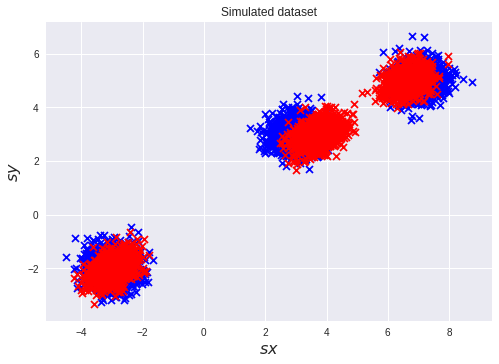

In [25]:
print(_s)
print(_o["o"])
print(data["s"])

# plt.scatter(sample_o[:,0],sample_o[:,1],color='blue',marker='o',edgecolors="blue")
plt.scatter(data["o"][:,0],data["o"][:,1],color='blue',marker='x',edgecolors="red")
plt.scatter(_o["o"][:,0],_o["o"][:,1],color='red',marker='x',edgecolors="red")
plt.xlabel('$sx$', fontsize=16)
plt.ylabel('$sy$', fontsize=16)
plt.title("Simulated dataset")
plt.show()

In [26]:
loss=0
_ss=_s["s"]
for i in range(0,sample_num-1,1):
    loss+=np.abs(data["s"][i].numpy()-_ss[i])
print(loss/sample_num)

tensor([0.4479, 0.3638])


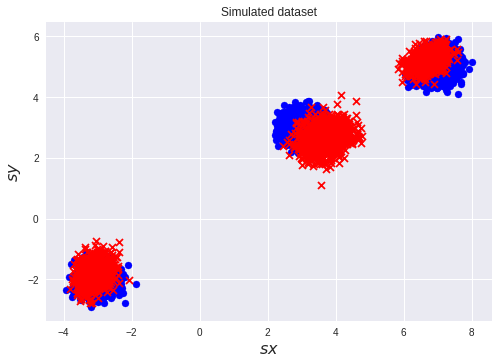

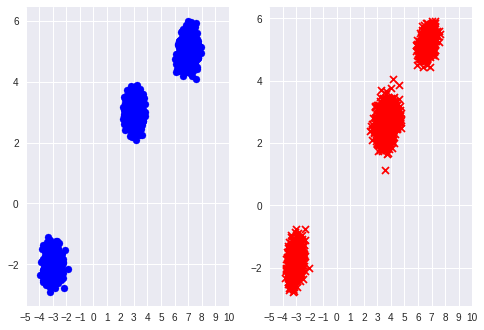

In [27]:
max_data=10#max_data
min_data=-4#min_data
grid_inter=1

plot_data=test_data

_s = q.sample({"o": plot_data["o"].to(device), "c": plot_data["c"].to(device)}, return_all=False)

#show sample points
plt.scatter(plot_data["s"][:,0],plot_data["s"][:,1],color='blue',marker='o',edgecolors="blue")
plt.scatter(_s["s"][:,0],_s["s"][:,1],color='red',marker='x',edgecolors="red")
plt.xlabel('$sx$', fontsize=16)
plt.ylabel('$sy$', fontsize=16)
plt.title("Simulated dataset")
plt.show()

plt.subplot(1, 2, 1)
plt.scatter(plot_data["s"][:,0],plot_data["s"][:,1],color='blue',marker='o',edgecolors="blue")
plt.xticks(np.arange(min_data-1,max_data+1,grid_inter))
plt.subplot(1,2,2)
plt.scatter(_s["s"][:,0],_s["s"][:,1],color='red',marker='x',edgecolors="red")
plt.xticks(np.arange(min_data-1,max_data+1,grid_inter))
plt.show()
